In [1]:
import datetime

import pandas as pd

from config import stocks
from config import general as config
from finrl.agents.stablebaselines3.drl_ensemble_agent import DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_baseline
from lib.drl import load_dataset
from lib.support import check_directory_structure

check_directory_structure()

C:\Users\Crabs\Anaconda3\envs\finrl37\lib\site-packages\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


In [2]:
FILE_PREFIX = "stocks"
ROOT_DIR = '.'
processed_full = load_dataset(f'{ROOT_DIR}/datasets/stocks/DOW30.csv', stocks.INDICATORS_LIGHT, use_turbulence=True, use_vix=False)

stock_dimension = len(processed_full.tic.unique())
tech_indicators = stocks.INDICATORS_LIGHT

state_space = 1 + 2 * stock_dimension + len(tech_indicators) * stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": tech_indicators,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
    "print_verbosity": 5
}

Loaded 99341 rows from file ./datasets/stocks/DOW30.csv
Adding 4 indicators: macd, rsi_30, cci_30, dx_30
Adding turbulence index
Stock Dimension: 29, State Space: 175


In [3]:
# rebalance_window is the number of days to retrain the model
rebalance_window = 63

# validation_window is the number of days to do validation and trading (e.g. if validation_window=63,
# then both validation and trading period will be 63 days)
validation_window = 63

# train_start = '2009-04-01'
train_start = '2018-04-01'
# train_end = '2021-04-01'
train_end = '2021-11-01'
# val_test_start = '2021-04-01'
val_test_start = '2021-11-01'
val_test_end = '2022-06-01'

In [4]:
A2C_model_kwargs = {'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0005}
PPO_model_kwargs = {"ent_coef": 0.01, "n_steps": 2048, "learning_rate": 0.00025, "batch_size": 64}
DDPG_model_kwargs = {"buffer_size": 10_000, "learning_rate": 0.0005, "batch_size": 64}
timesteps_dict = {'A2C': 25, 'PPO': 25, 'DDPG': 25}

In [5]:
ensemble_agent = DRLEnsembleAgent(df=processed_full,
                                  train_period=(train_start, train_end),
                                  val_test_period=(val_test_start, val_test_end),
                                  rebalance_window=rebalance_window,
                                  validation_window=validation_window,
                                  root_dir=ROOT_DIR,
                                  trained_model_dir=config.TRAINED_MODEL_DIR,
                                  results_dir=config.RESULTS_DIR,
                                  tensorboard_log_dir=config.TENSORBOARD_LOG_DIR,
                                  **env_kwargs)

In [6]:
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs, PPO_model_kwargs, DDPG_model_kwargs, timesteps_dict)

============Start Ensemble Strategy============
Initial: True
turbulence_threshold:  356.6735770161969
======Model training from: 2018-04-01 to 2021-11-02
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0005}
Using cpu device
Logging to ./tensorboard_log/A2C\A2C_126_6
======A2C Validation from: 2021-11-02 to 2022-02-02
A2C Sharpe Ratio:  -0.041445376044316896
======PPO Training========
{'ent_coef': 0.01, 'n_steps': 2048, 'learning_rate': 0.00025, 'batch_size': 64}
Using cpu device
Logging to ./tensorboard_log/PPO\PPO_126_5
---------------------------------
| time/              |          |
|    fps             | 294      |
|    iterations      | 1        |
|    time_elapsed    | 6        |
|    total_timesteps | 2048     |
| train/             |          |
|    reward          | 0.690091 |
---------------------------------
======PPO Validation from: 2021-11-02 to 2022-02-02
PPO Sharpe Ratio:  -0.15791322240381436
======DDPG Training========
{'buffer_size'

In [7]:
df_summary

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe
0,126,2021-11-02,2022-02-02,A2C,-0.041445,-0.157913,-0.050488


In [8]:
unique_trade_date = processed_full[
    (processed_full.date > val_test_start) & (processed_full.date <= val_test_end)].date.unique()

df_trade_date = pd.DataFrame({'datadate': unique_trade_date})

df_account_value = pd.DataFrame()
for i in range(rebalance_window + validation_window, len(unique_trade_date) + 1, rebalance_window):
    temp = pd.read_csv(f"{ROOT_DIR}/results/account_value_trade_ensemble_{i}.csv")
    df_account_value = df_account_value.append(temp, ignore_index=True)
sharpe = (252 ** 0.5) * df_account_value.account_value.pct_change(1).mean() / df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ', sharpe)
df_account_value = df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  -0.9733420974140132


In [9]:
df_account_value.head()

,account_value,date,daily_return,datadate
0,1.000000e+06,2022-02-02,NaN,2022-02-02
1,9.978186e+05,2022-02-03,-0.002181,2022-02-03
2,9.979327e+05,2022-02-04,0.000114,2022-02-04
3,9.976153e+05,2022-02-07,-0.000318,2022-02-07
4,1.000420e+06,2022-02-08,0.002811,2022-02-08


<AxesSubplot:>

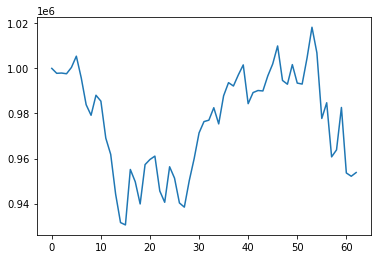

In [10]:
%matplotlib inline
df_account_value.account_value.plot()

In [11]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return         -0.172393
Cumulative returns    -0.046203
Annual volatility      0.180869
Sharpe ratio          -0.973342
Calmar ratio          -2.315492
Stability              0.037486
Max drawdown          -0.074452
Omega ratio            0.851549
Sortino ratio         -1.261560
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.910319
Daily value at risk   -0.023486
dtype: float64


In [12]:
# baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
    ticker="^DJI",
    start=df_account_value.loc[0, 'date'],
    end=df_account_value.loc[len(df_account_value) - 1, 'date'])

stats = backtest_stats(baseline_df, value_col_name='close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Annual return         -0.239638
Cumulative returns    -0.066198
Annual volatility      0.191852
Sharpe ratio          -1.355580
Calmar ratio          -2.733735
Stability              0.029364
Max drawdown          -0.087660
Omega ratio            0.806698
Sortino ratio         -1.760912
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.775657
Daily value at risk   -0.025203
dtype: float64


==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed


Start date,2022-02-02
End date,2022-05-03
Total months,3
,Backtest
Annual return,-17.239%
Cumulative returns,-4.62%
Annual volatility,18.087%
Sharpe ratio,-0.97
Calmar ratio,-2.32
Stability,0.04
Max drawdown,-7.445%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,7.45,2022-02-09,2022-02-24,2022-04-08,43
1,6.49,2022-04-20,2022-05-02,NaT,NaN
2,1.68,2022-04-08,2022-04-12,2022-04-20,9
3,0.24,2022-02-02,2022-02-07,2022-02-08,5
4,NaN,NaT,NaT,NaT,NaN


C:\Users\Crabs\Anaconda3\envs\finrl37\lib\site-packages\pyfolio\timeseries.py:1230: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  period = returns_dupe.loc[start:end]


Stress Events,mean,min,max
New Normal,-0.07%,-2.96%,2.64%


C:\Users\Crabs\Anaconda3\envs\finrl37\lib\site-packages\pyfolio\timeseries.py:1230: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  period = returns_dupe.loc[start:end]


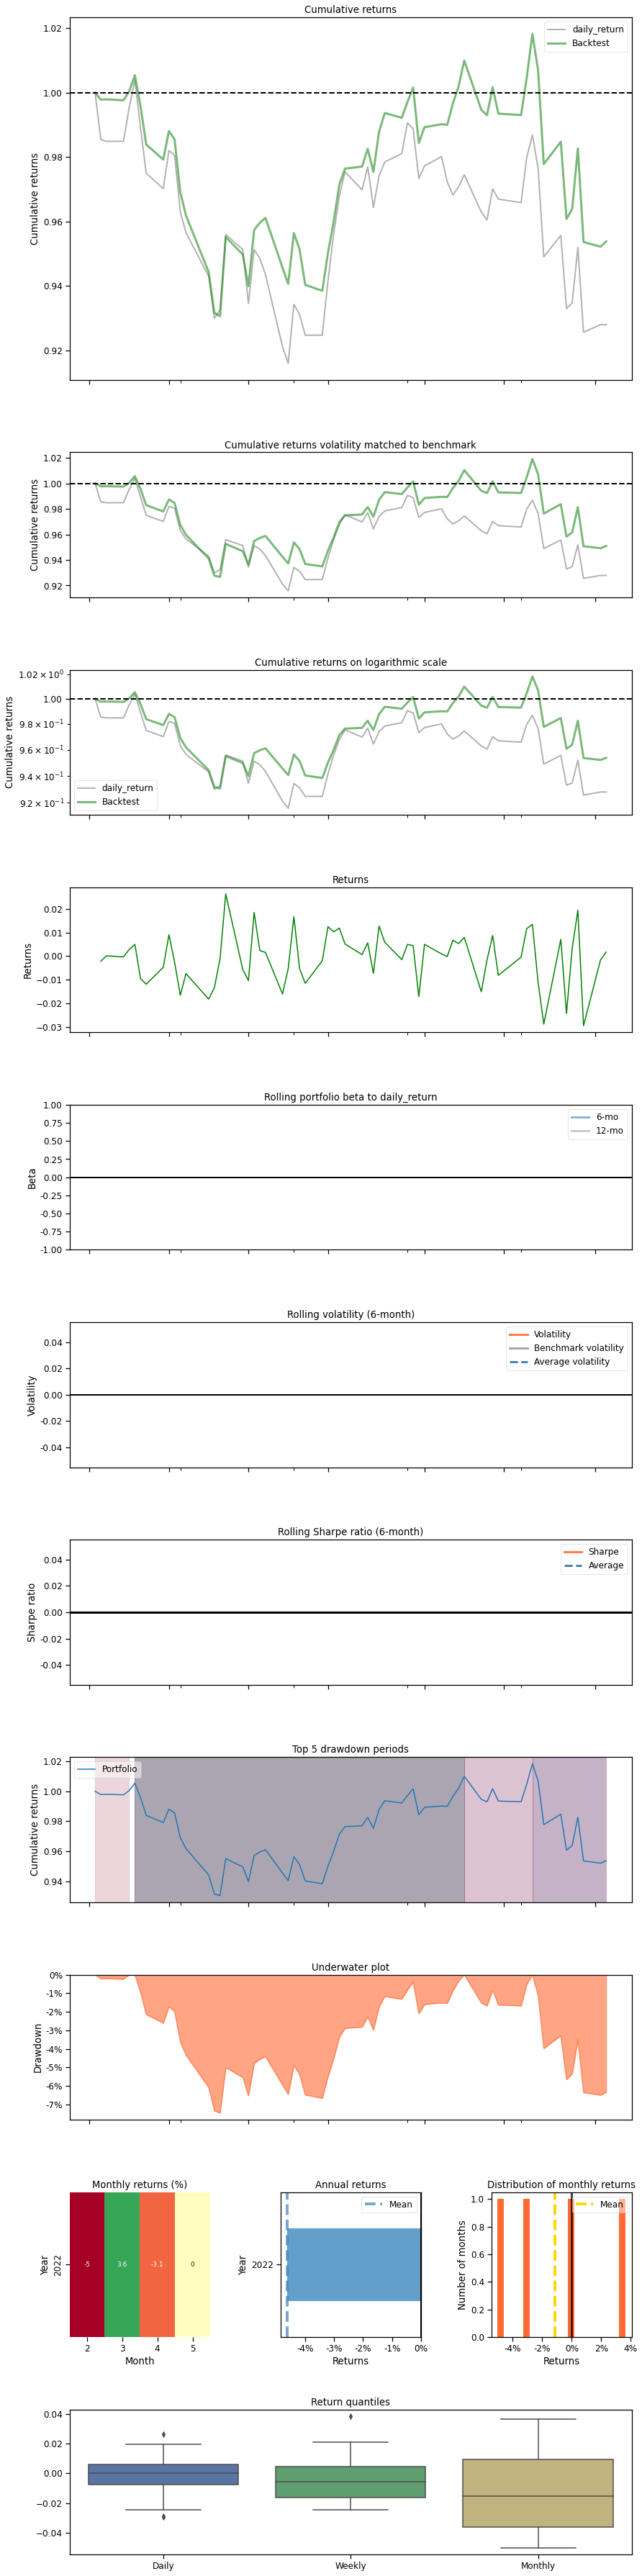

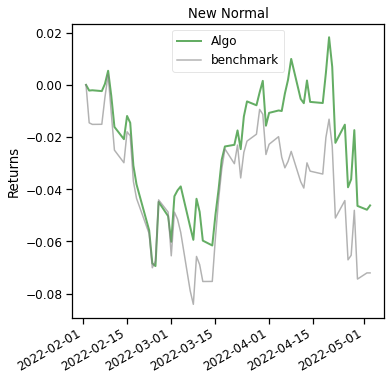

In [13]:
print("==============Compare to DJIA===========")
# %matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value,
              baseline_ticker='^DJI',
              baseline_start=df_account_value.loc[0, 'date'],
              baseline_end=df_account_value.loc[len(df_account_value) - 1, 'date'])

In [ ]:
print("done")